In [1]:
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(ISOweek)
library(scales)
library(zoo)
library(tidyr)
library(quantreg)
library(splines)
library(pbs)
library(forecast)
require(RcppRoll)
library(fpp2)
library(xts)
theme_set(theme_bw())
get_percentage = function(x) {
    (exp(x) - 1) * 100
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: RcppRoll

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘RcppRoll’”
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────── fpp2 2.4 ──

✔ fma       2.

In [2]:
# You can also redownload the data with the get_data.r script
# The data seems to be
df = read.csv("../data/stmf.csv", skip=1)
n_rows = nrow(df)

In [3]:
df["Weekday"] = "1"
df$Week = str_pad(df$Week, 2, pad="0")
data = df %>% unite(Weekdate, "Year", "Week", sep="-W", remove=FALSE)
data = data %>% unite(Weekdate, "Weekdate", "Weekday", sep="-")
data$Date = ISOweek2date(data$Weekdate)
death_cols = c("D0_14", "D15_64", "D65_74", "D75_84", "D85p")
rate_cols = c("R0_14", "R15_64", "R65_74", "R75_84", "R85p")
base_cols = c("CountryCode", "Weekdate", "Year", "Week", "Sex")
data = data %>% pivot_longer(all_of(c(death_cols, rate_cols)), names_pattern="(.)(.*)", names_to=c("Type", "Age")) %>% pivot_wider(names_from=Type, values_from=value)# data$Pop = data$Deaths / data$Rates
data = rename(data, Deaths = D)
data = rename(data, Rates = R)
data$Pop = data$Deaths / data$Rates

data = data %>% group_by(Age, Sex, CountryCode) %>% fill(Pop, .direction="up")
data$Pop_int = data$Pop
data$Pop_int[data$Week != 52] = NA
data = data[data$Week != 53, ]
data = data %>%
    group_by(Sex, Age, CountryCode) %>%
    arrange(Date) %>%
    mutate(time=seq(1, n())) %>% 
    mutate(Pop_int=approx(time,Pop_int,time)$y) %>%
    fill(Pop_int, .direction="downup") %>%
    select(-time)
data$Rate_norm = data$Deaths / data$Pop_int

# European Standard population numbers
# Get the ESP groups
std_esp_pop = c(1000, 4000, 5500, 5500, 5500, 6000, 6000, 6500, 7000, 
            7000, 7000, 7000, 6500, 6000, 5500, 5000, 4000, 2500, 1500, 800, 200)
esp_group = cut(c(0:100), c(0,1,seq(5,95, 5), 200), right=FALSE)
age = c("0_14", "15_64", "65_74", "75_84", "85p")
esp_pop = c(sum(std_esp_pop[1:4]), sum(std_esp_pop[5:14]), sum(std_esp_pop[15:16]), sum(std_esp_pop[17:18]), sum(std_esp_pop[19:21]))
esp_df = data.frame(Age=age, Esp_pop=esp_pop)
esp_groups = levels(esp_group)
std_esp_df = data.frame(age=esp_groups, esp_pop=std_esp_pop)
data = merge(data, esp_df, by="Age")
data$Deaths_norm = data$Rate_norm * data$Esp_pop
sprintf("Fraction of data missing %.2f", dim(data[data$Deaths_norm==0,])[1] / dim(data)[1])
# With a smoother we are down to 3%. This is managable
# Define functions
weighted_mean = function(x) {
    nas = is.na(x)
    w = c(0.25, 0.5, 0.25)
    if (all(nas)) {
        return(0)
    } else {
        w = w[!nas] / sum(w[!nas])
        return(sum(x[!nas] * w))
    }
}
sprintf("Smoothing...")
data <- data %>% group_by(Age, CountryCode, Sex) %>% arrange(Sex, Age, Date) %>%
       mutate(Sdeaths_norm=rollapply(Deaths_norm, 3, weighted_mean, align='center', fill=NA))
sprintf("Fraction of data missing after smoothing %.2f", dim(data[data$Sdeaths_norm==0,])[1] / dim(data)[1])

data = data %>% fill(Sdeaths_norm, .direction="downup") %>% filter(Sdeaths_norm > 0)

head(data)

[1] "Fraction of data missing 0.02"

[1] "Fraction of data missing after smoothing 0.01"

Age,CountryCode,Weekdate,Year,Week,Sex,DTotal,RTotal,Split,SplitSex,Forecast,Date,Deaths,Rates,Pop,Pop_int,Rate_norm,Esp_pop,Deaths_norm,Sdeaths_norm
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0_14,FIN,1990-W01-1,1990,01,b,1146,0.01194916,0,0,0,1990-01-01,14,0.0007558188,18522.96,18522.96,0.0007558188,16000,12.093101,9.933619
0_14,FIN,1990-W02-1,1990,02,b,1139,0.01187618,0,0,0,1990-01-08,10,0.0005398706,18522.96,18522.96,0.0005398706,16000,8.637929,9.933619
0_14,FIN,1990-W03-1,1990,03,b,1185,0.01235581,0,0,0,1990-01-15,12,0.0006478447,18522.96,18522.96,0.0006478447,16000,10.365515,8.853877
0_14,FIN,1990-W04-1,1990,04,b,1164,0.01213685,0,0,0,1990-01-22,7,0.0003779094,18522.96,18522.96,0.0003779094,16000,6.046550,7.774136
0_14,FIN,1990-W05-1,1990,05,b,1103,0.01150081,0,0,0,1990-01-29,10,0.0005398706,18522.96,18522.96,0.0005398706,16000,8.637929,8.206033
0_14,FIN,1990-W06-1,1990,06,b,1065,0.01110459,0,0,0,1990-02-05,11,0.0005938576,18522.96,18522.96,0.0005938576,16000,9.501722,7.558188


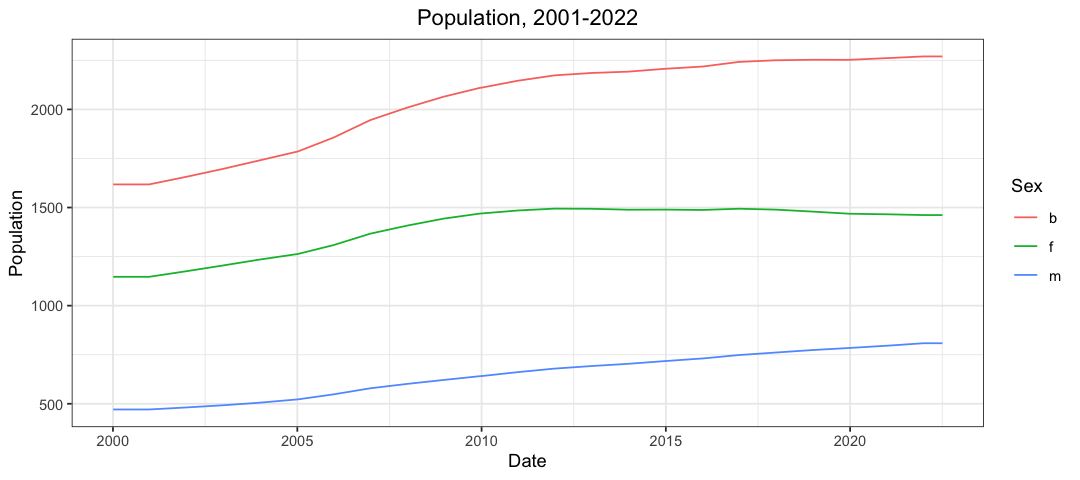

In [5]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(subset(data, Age=="85p" & CountryCode=="NOR") %>% group_by(Sex) %>% arrange(Sex, Date), aes(Date, Pop_int, color=Sex)) + geom_line() + 
labs(x="Date", y="Population", title="Population, 2001-2022", color="Sex") + 
theme(plot.title=element_text(hjust=.5))

In [62]:
mortality_fit = function(
    data, 
    # Parameters
    years_per_df = 5,
    df.weekly = 7,
    alpha=0.10,
    response.col = "Sdeaths_norm",
    debug=FALSE) {
    # This function fits trends and confidence intervals at the alpha level
    # Enforced column names in input data
    
    test_start_year = 2020
    start_year = 2012
    
    week.col = "Week"
    year.col = "Year"
    date.col = "Date"
    sex.col = "Sex"
    country.col = "CountryCode"
    age.col = "Age"

    all = data.frame(date = data[,date.col],
                    week = as.numeric(unlist(data[,week.col])),
                    year = as.numeric(unlist(data[,year.col])),
                    response=log(data[, response.col]),
                    sex = as.factor(unlist(data[,sex.col])),
                    country = as.factor(unlist(data[,country.col])),
                    age = as.factor(unlist(data[,age.col])))
    
    colnames(all) = c("date", "week", "year", "response", "sex", "country", "age")
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    print(sprintf("Using %d degrees of freedom in yearly splines for %s, %s, %s", 
            df.yearly, all$country[1], all$age[1], all$sex[1]))
    all = subset(all, year(date) > start_year)
    train = subset(all, year(date) < test_start_year)
    test = subset(all, year(date) >= test_start_year)

    yearly.fit = rq(response ~ ns(date, df=df.yearly), data=train)

    train[, "res.yearly"] = yearly.fit$res
    train[, "fit.yearly"] = yearly.fit$fit
    weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=df.weekly), data=train)
    
    train[, "fit.weekly"] = weekly.fit$fit
    train[, "res.weekly"] = weekly.fit$res
    train = train %>% mutate(centered = response - fit.weekly - fit.yearly)
    # Set test date to last train date to fix yearly trend in test period
    mod_date = all$date
    mod_date[year(mod_date) >= test_start_year] = as.Date("2019-12-31", "%Y-%m-%d")
    mod_all = data.frame(date=mod_date, week=all$week)
    all$fit.yearly = predict(yearly.fit, newdata=mod_all)
    all$fit.weekly = predict(weekly.fit, newdata=mod_all)
    
    all = all %>% mutate(centered = response - fit.weekly - fit.yearly)
    n_train = nrow(train)
    n_all = nrow(all)
    fit.low = quantile(train$centered, alpha/2)
    fit.high = quantile(train$centered, 1 - alpha/2)
#     fit.low = rq(centered ~ 1, data=train, tau=alpha/2)
#     fit.high = rq(centered ~ 1, data=train, tau=1-alpha/2)
#     train$centered_high = rq.fit.high$fit
#     train$centered_low = rq.fit.low$fit
    train$centered_high = rep(fit.high, n_train)
    train$centered_low = rep(fit.low, n_train)
    all$centered_high = rep(fit.high, n_all)
    all$centered_low = rep(fit.low, n_all)
#     all$centered_high = predict(rq.fit.high, newdata=all)
#     all$centered_low = predict(rq.fit.low, newdata=all)
    test = subset(all, year(date) > 2020)
    frac_outside = sum(train$centered < train$centered_low | train$centered > train$centered_high) / nrow(train)
    frac_outside_test = sum(test$centered < test$centered_low | test$centered > test$centered_high) / nrow(test)
    frac_over_test = sum(test$centered > test$centered_high) / nrow(test)
    if (debug) {
        print(sprintf("Fraction of observations outside confidence band in pre-2020: %.3f", frac_outside))
        print(sprintf("Fraction of observations outside confidence band in 2021: %.3f", frac_outside_test))
        print(sprintf("Fraction of observations over confidence band in 2021: %.3f", frac_over_test))
    }
    return(all)
}

plot_debug = function(df) {
    ggplot(df, aes(date, response)) + geom_line(alpha=0.3) + 
    geom_line(aes(date, fit.yearly), size=1.5, color="blue") + 
    geom_line(aes(date, fit.weekly + fit.yearly), size=1.5, color="gold") +
    labs(x="Date", y="Deaths [per 100k per week]", title="Anomalous Mortality 2012-2022") 
}
plot_mortality = function(df) {
    ggplot(df, aes(date, get_percentage(centered))) + geom_line(alpha=0.3) + 
    geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
    geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
    labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") 

}

In [65]:
stratified = data %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm"), keep=TRUE)
stratified = do.call(rbind, stratified)

[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, m"
[1] "Using 2 degrees of freedom in yearly

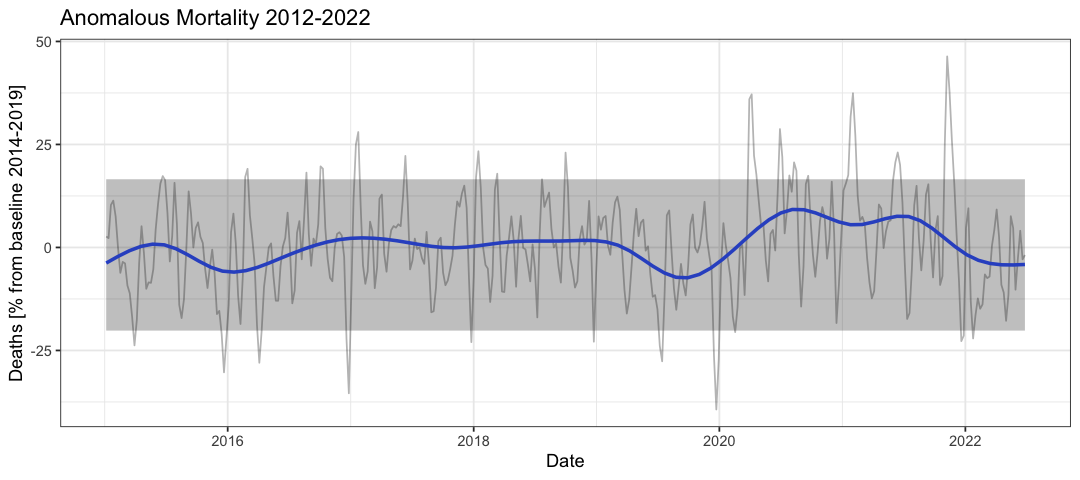

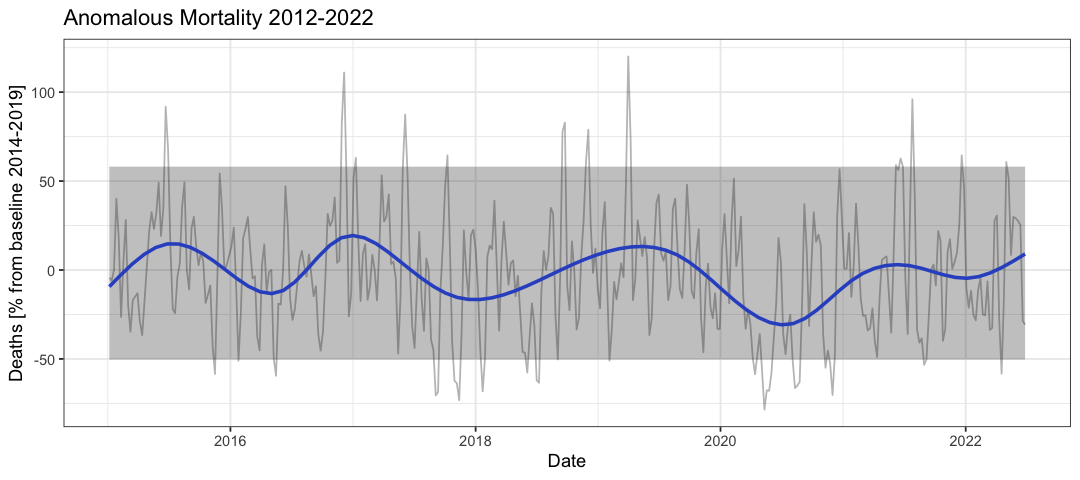

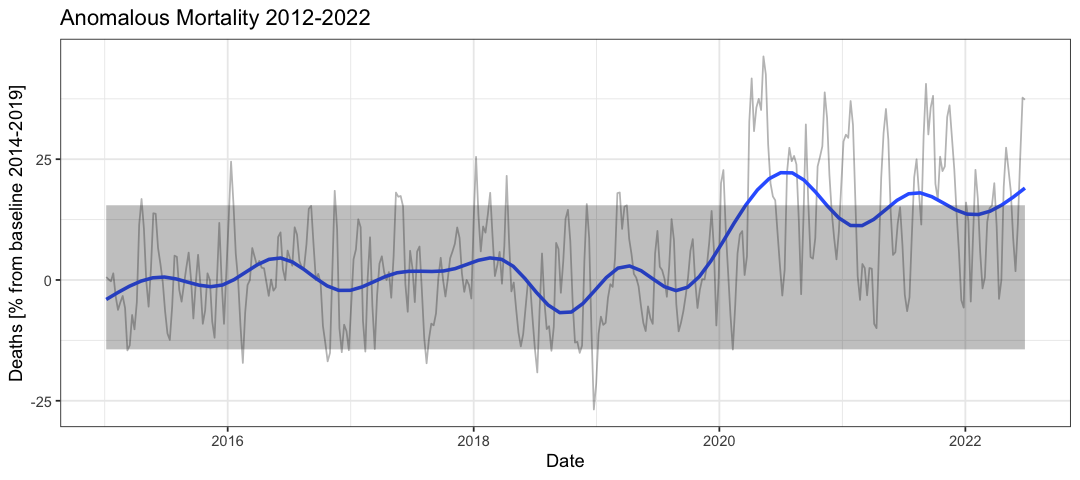

In [66]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
plot_mortality(subset(stratified, country=="GBR_NIR" & age=="15_64" & sex=="b"))
plot_mortality(subset(stratified, country=="GBR_NIR" & age=="0_14" & sex=="b"))
plot_mortality(subset(stratified, country=="GBR_NIR" & age=="65_74" & sex=="b"))

[1] "Using 2 degrees of freedom in yearly splines for GBR_NIR, 0_14, b"


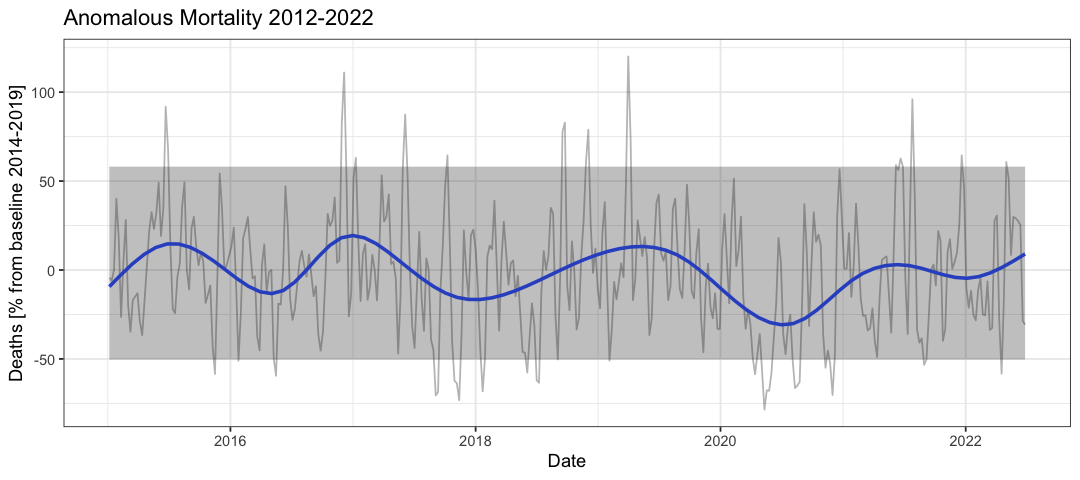

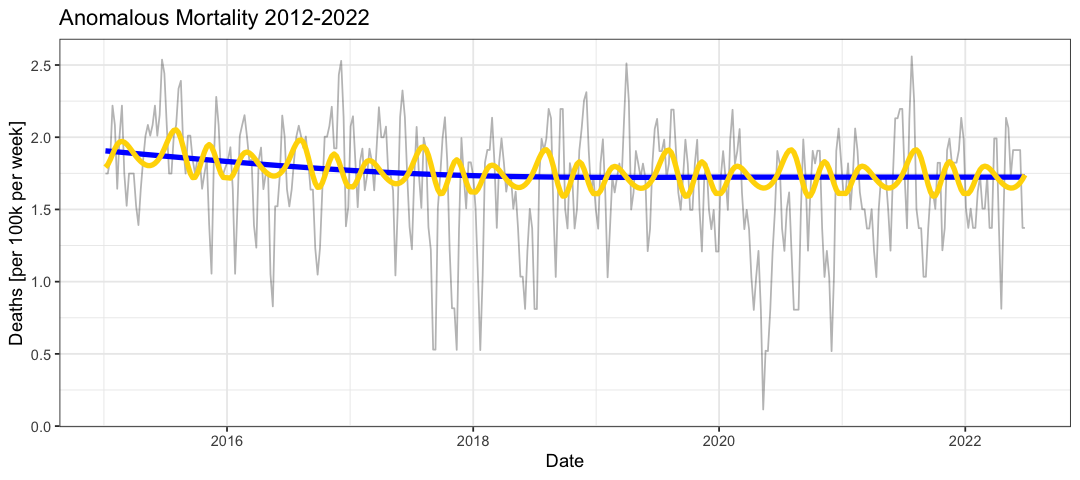

In [67]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
cdata = subset(data, CountryCode=="GBR_NIR" & Age=="0_14" & Sex=="b" & Sdeaths_norm > 0)
all = mortality_fit(cdata, response.col="Sdeaths_norm")
plot_mortality(all)
plot_debug(all)

In [362]:
# Sum age groups' deaths and population
all_ages = data %>% group_by(Date, CountryCode, Sex) %>% 
    summarise(Sdeaths_norm=sum(Sdeaths_norm),
             Date=Date, Week=Week, Year=Year, Age="all") %>% distinct()
head(all_ages)

`summarise()` has grouped output by 'Date', 'CountryCode', 'Sex'.
You can override using the `.groups` argument.


Date,CountryCode,Sex,Sdeaths_norm,Week,Year,Age
<date>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1990-01-01,FIN,b,1820.457,01,1990,all
1990-01-01,FIN,f,1519.273,01,1990,all
1990-01-01,FIN,m,2354.494,01,1990,all
1990-01-08,FIN,b,1820.457,02,1990,all
1990-01-08,FIN,f,1519.273,02,1990,all
1990-01-08,FIN,m,2354.494,02,1990,all


           date week year response sex country age
Sex1 1990-01-01    1 1990 7.506843   b     FIN all
[1] "Fraction of observations outside confidence band in pre-2020: 0.099"
[1] "Fraction of observations outside confidence band in 2021: 0.378"
[1] "Fraction of observations over confidence band in 2021: 0.351"


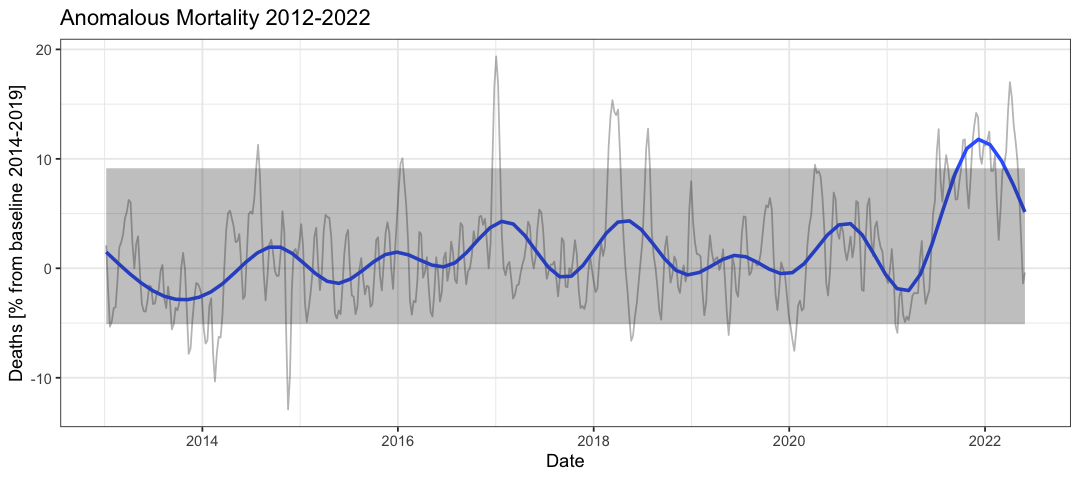

In [363]:
cdata = subset(all_ages, CountryCode=="FIN" & Sex=="b")
all = mortality_fit(cdata)
plot_mortality(all)

In [364]:
res = all_ages %>% group_by(CountryCode, Sex) %>% group_map(~ mortality_fit(.x), keep=TRUE)
all_ages_df = do.call(rbind, res)

           date week year response sex country age
Sex1 2014-12-29    1 2015 6.641767   b     AUS all
[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.234"
[1] "Fraction of observations over confidence band in 2021: 0.141"
           date week year response sex country age
Sex1 2014-12-29    1 2015 6.494795   f     AUS all
[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.172"
[1] "Fraction of observations over confidence band in 2021: 0.156"
           date week year response sex country age
Sex1 2014-12-29    1 2015 6.787181   m     AUS all
[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.250"
[1] "Fraction of observations over confidence band in 2021: 0.125"
           date week year response sex country age
Sex1 2000-

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.423"
[1] "Fraction of observations over confidence band in 2021: 0.372"
           date week year response sex country age
Sex1 2015-01-05    2 2015 7.077055   f GBR_NIR all


Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.359"
[1] "Fraction of observations over confidence band in 2021: 0.346"
           date week year response sex country age
Sex1 2015-01-05    2 2015 7.314704   m GBR_NIR all


Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.462"
[1] "Fraction of observations over confidence band in 2021: 0.372"
           date week year response sex country age
Sex1 2000-01-10    2 2000 7.630293   b GBR_SCO all
[1] "Fraction of observations outside confidence band in pre-2020: 0.099"
[1] "Fraction of observations outside confidence band in 2021: 0.367"
[1] "Fraction of observations over confidence band in 2021: 0.278"
           date week year response sex country age
Sex1 2000-01-10    2 2000 7.487614   f GBR_SCO all
[1] "Fraction of observations outside confidence band in pre-2020: 0.099"
[1] "Fraction of observations outside confidence band in 2021: 0.392"
[1] "Fraction of observations over confidence band in 2021: 0.228"
           date week year response sex country age
Sex1 2000-01-10    2 2000 7.807006   m GBR_SCO all
[1] "Fraction of observations outside confidence band in pre-

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.824"
[1] "Fraction of observations over confidence band in 2021: 0.784"
           date week year response sex country age
Sex1 2015-01-05    2 2015 6.998408   f     USA all


Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.784"
[1] "Fraction of observations over confidence band in 2021: 0.743"
           date week year response sex country age
Sex1 2015-01-05    2 2015 7.286579   m     USA all


Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


[1] "Fraction of observations outside confidence band in pre-2020: 0.100"
[1] "Fraction of observations outside confidence band in 2021: 0.878"
[1] "Fraction of observations over confidence band in 2021: 0.811"


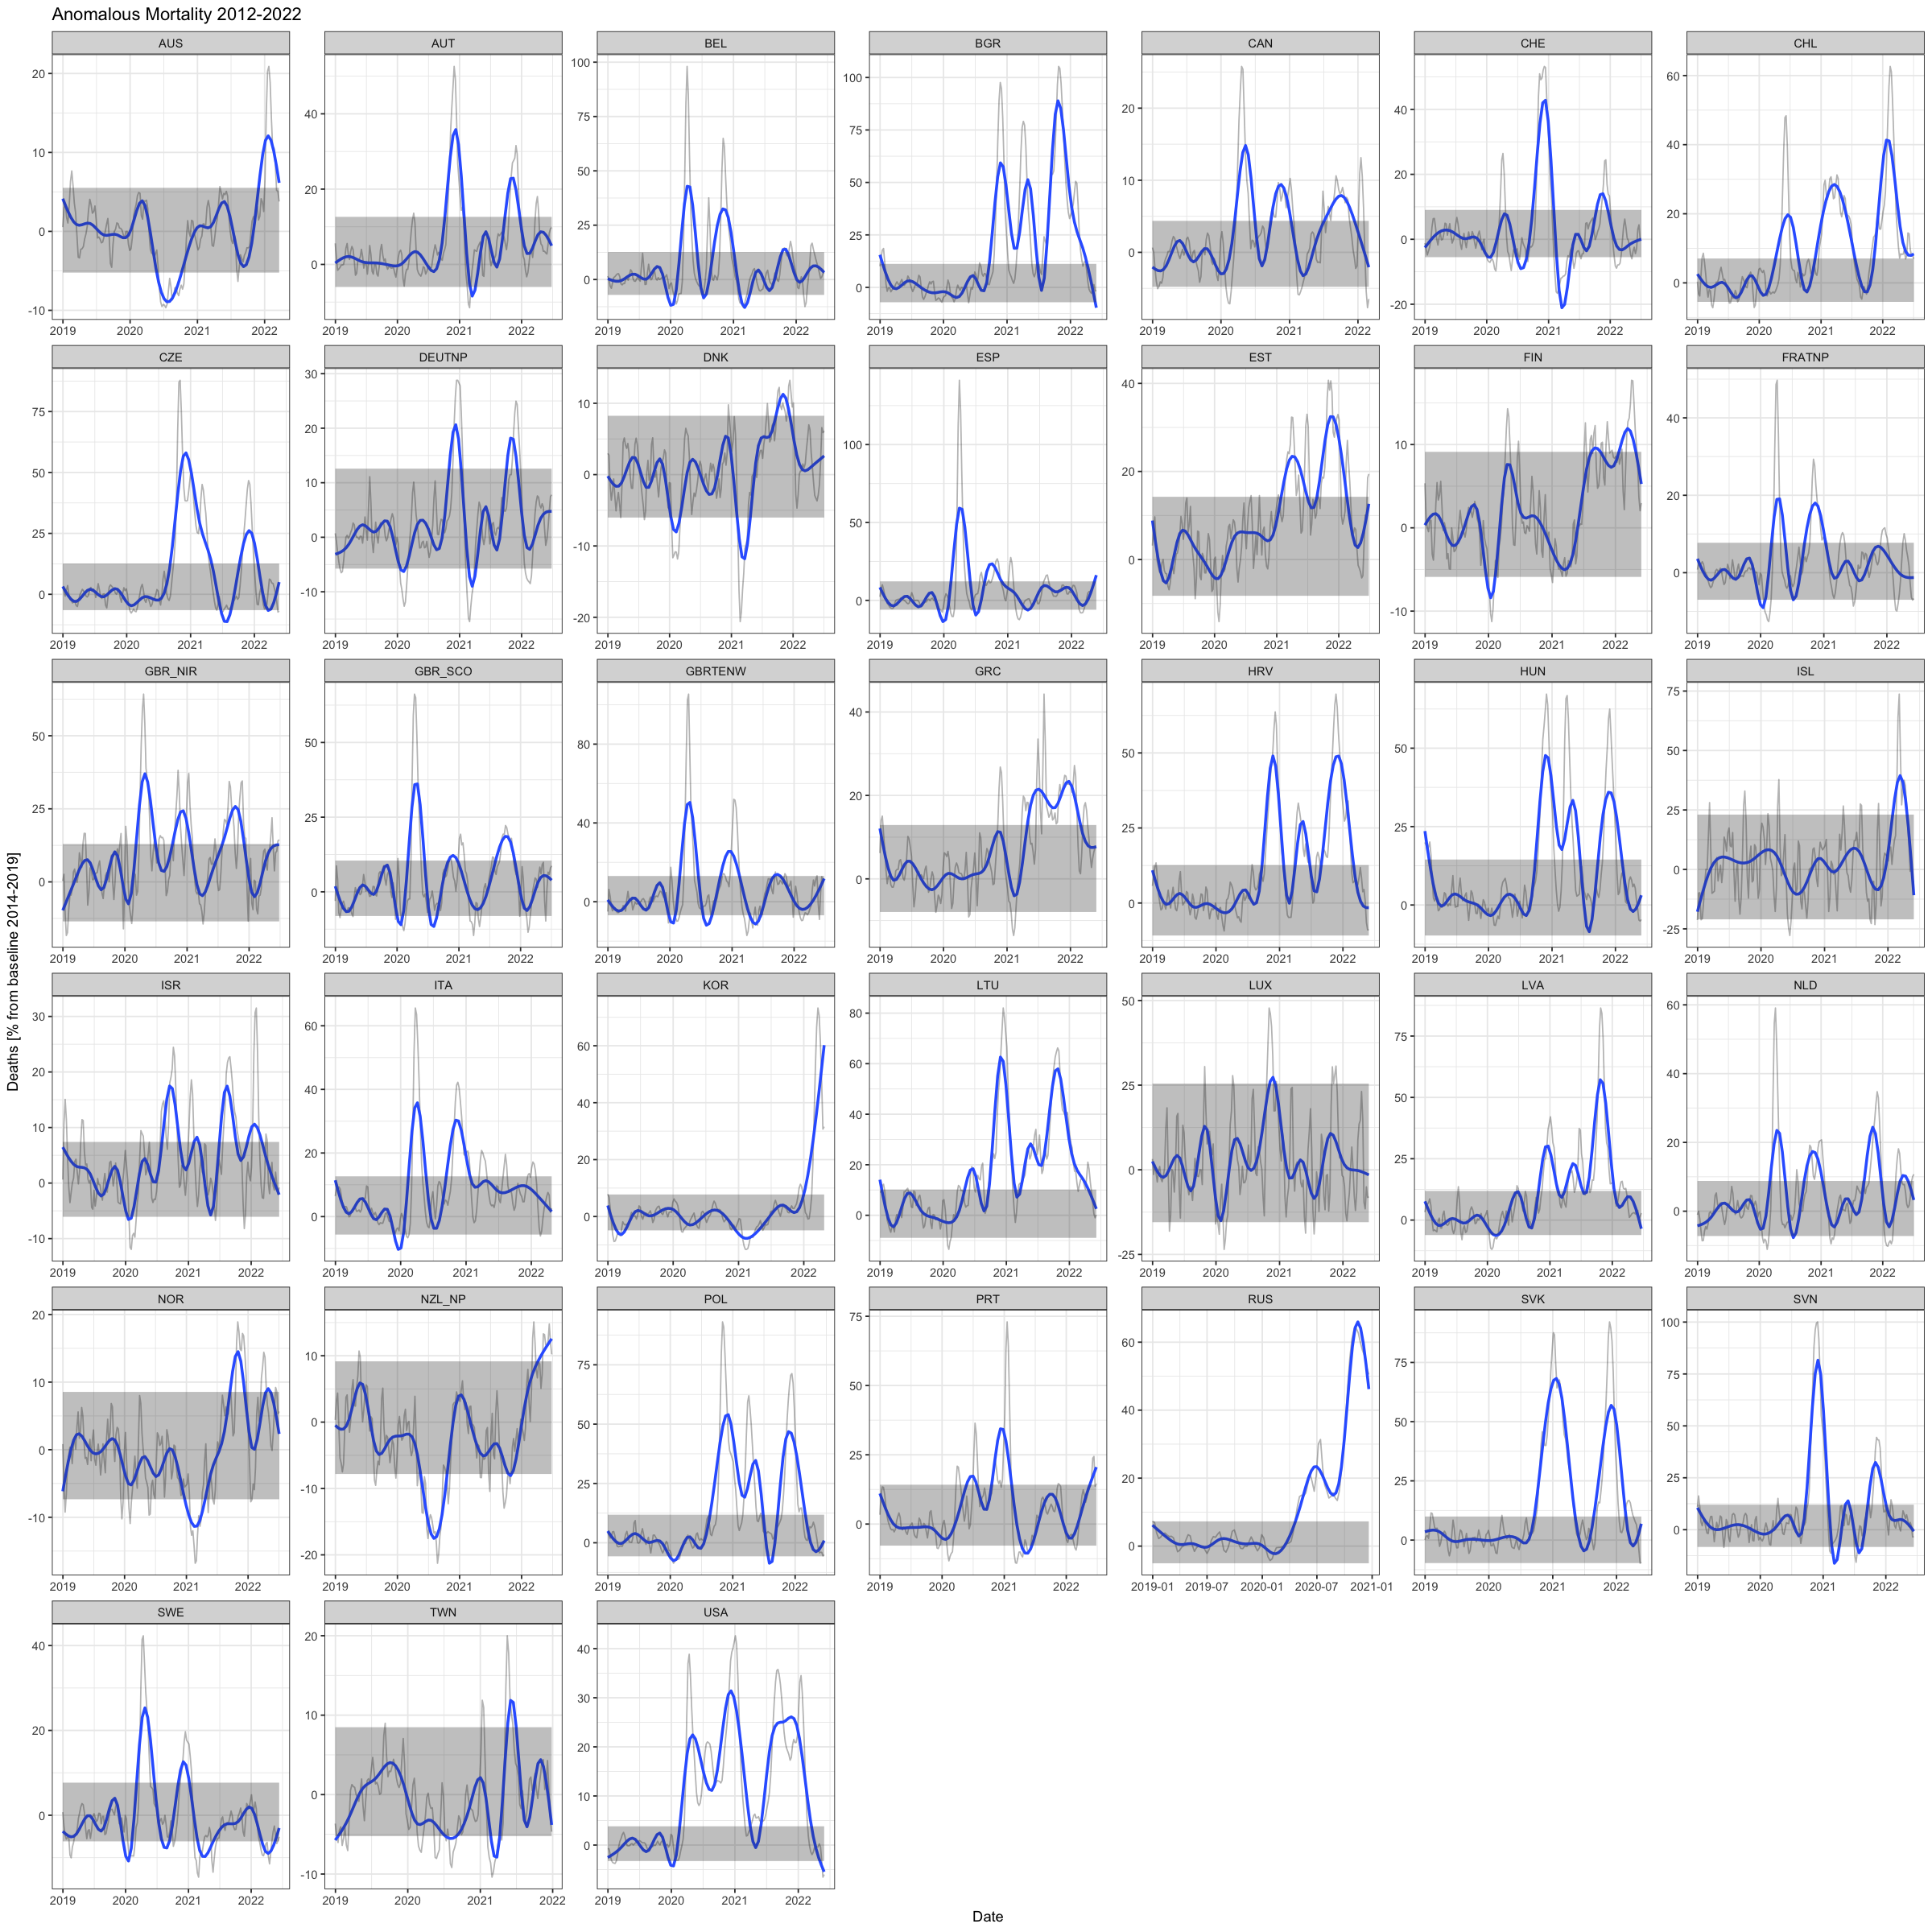

In [365]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(subset(all_ages_df, sex=="f" & year >= 2019), aes(date, get_percentage(centered))) + geom_line(alpha=0.3) + 
geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free")